# An Investigation of Danish Fertility

In the recent years, danish policymakers have expressed concern for the state of the national fertility rates. According to the danish newspaper Berlingske, a danish woman would in 2022 on average give birth to 1,55 children (see [this website](https://www.berlingske.dk/samfund/foedselsraten-falder-i-naesten-alle-landsdele-koebenhavn-er-blandt-de)). 
To sustain the population size without taking immigration into consideration, a woman would need to give birth to 2,1 children. However cynical it may sound, it is of great economical interest why the fertility rates are declining, because policy makers are already introducing measures to deal with the decline. In her new years speech, the prime mininister adressed to the nation that extra rounds of fertility treatment would become accessible for free for danish women in the forthcoming year. In this projject, we investigate the determining factors for the danish fertility.


Imports and set magics:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import mpl_axes_aligner
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


In [2]:
pip install mpl-axes-aligner

  Preparing metadata (setup.py) ... done
  Created wheel for mpl-axes-aligner: filename=mpl_axes_aligner-1.3-py3-none-any.whl size=4753 sha256=b2f507444e5a064202780b06df8ff4b0b35b0ad5fa99b47b67d19c7a28beba35
  Stored in directory: /Users/annesophiehaekkerup/Library/Caches/pip/wheels/fb/c5/83/3e57a13e29e717ea464107db3f256122f336836008bd8e5719
Successfully built mpl-axes-aligner
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/alemartinello/dstapi

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/0m/qwwfwwkj7h7cv9bpwkmc0drh0000gn/T/pip-req-build-r_uma2ag
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/0m/qwwfwwkj7h7cv9bpwkmc0drh0000gn/T/pip-req-build-r_uma2ag
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
from IPython.display import display
import requests
from dstapi import DstApi

In [6]:
from dataproject import*
BNP = data_NAN1()
BNP.head()

,TRANSAKT,PRISENHED,TID,INDHOLD
0,B.1*g Gross domestic product,Period-to-period real growth (per cent),1979,3.9
1,B.1*g Gross domestic product,Period-to-period real growth (per cent),2022,2.7
2,B.1*g Gross domestic product,Period-to-period real growth (per cent),2005,2.3
3,B.1*g Gross domestic product,Period-to-period real growth (per cent),1985,4.0
4,B.1*g Gross domestic product,Period-to-period real growth (per cent),1991,1.4


In [7]:
# Clean and rename dataset on GDP

# a. drop the descriptive columns "TRANSAKT" and "PRISENHED"
drop_these = ['TRANSAKT','PRISENHED']
BNP.drop(drop_these, axis=1, inplace=True)

# b. rename columns to more suitable variable names
BNP.rename(columns = {'INDHOLD':'g'}, inplace=True)

# c. drop missing entries
I = BNP.loc[BNP.g == '..'] 
BNP.drop(I.index, inplace=True)

# d. sort dataset by year
BNP.sort_values(by = ['TID'], inplace=True)

# e. convert all entries to float
BNP['g'] = BNP['g'].astype('float')
BNP.head()


,TID,g
48,1967,5.5
55,1968,5.6
17,1969,6.5
26,1970,1.6
53,1971,3.0


In [8]:
HIS = data_HISB3()
HIS.head()

,BEVÆGELSE,TID,INDHOLD
0,"Women January 1. (in 1,000)",2000,2696
1,Total number of livebirths,2000,67084
2,"Women January 1. (in 1,000)",2001,2705
3,Total number of livebirths,2001,65458
4,"Women January 1. (in 1,000)",2002,2714


In [9]:
# clean and rename dataset on births and amount of women

# a. sort dataset on year and variable
HIS.sort_values(by = ['TID','BEVÆGELSE'], inplace=True)

# b. create subsets of odd and even rows to separate births and amount of women
even = HIS.iloc[::2]
odd = HIS.iloc[1::2]

# c. rename the column "INDHOLD" to births
even.rename(columns={'INDHOLD':'births'}, inplace=True)
print(even)

# d. rename the column "INDHOLD" to women
odd.rename(columns = {'INDHOLD': 'women'}, inplace=True)

# e. merge the subsets on year
res = pd.merge(even, odd, how='inner', on=['TID'])

# f. drop descriptive columns
drop = ['BEVÆGELSE_x', 'BEVÆGELSE_y']
res.drop(drop,axis=1,inplace=True)

# g. drop missing entries
res = res.dropna()
I = res.loc[res.births == '..'] 
res.drop(I.index, inplace=True)
I_2 = res.loc[res.women == '..'] 
res.drop(I_2.index, inplace=True)

# h. convert entry type to float
res['births'] = res['births'].astype('float')
res['women'] = res['women'].astype('float')

res.head()


                      BEVÆGELSE   TID births
237  Total number of livebirths  1901  73219
167  Total number of livebirths  1902  72839
140  Total number of livebirths  1903  72351
178  Total number of livebirths  1904  73692
141  Total number of livebirths  1905  73082
..                          ...   ...    ...
67   Total number of livebirths  2020  60937
41   Total number of livebirths  2021  63473
33   Total number of livebirths  2022  58430
53   Total number of livebirths  2023  57469
35   Total number of livebirths  2024     ..

[124 rows x 3 columns]


/var/folders/0m/qwwfwwkj7h7cv9bpwkmc0drh0000gn/T/ipykernel_12800/2758457094.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even.rename(columns={'INDHOLD':'births'}, inplace=True)
/var/folders/0m/qwwfwwkj7h7cv9bpwkmc0drh0000gn/T/ipykernel_12800/2758457094.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odd.rename(columns = {'INDHOLD': 'women'}, inplace=True)


,TID,births,women
0,1901,73219.0,1255.0
1,1902,72839.0,1271.0
2,1903,72351.0,1286.0
3,1904,73692.0,1300.0
4,1905,73082.0,1316.0


In [10]:
# a. calculate fertility as births per 1000 women in a new column
res['fertility'] = res['births']/res['women']

# b. calculate yearly change in fertility in a new column
res['rate'] = res['fertility'].pct_change()

# remove NaN
res = res.dropna() 
res.head()

,TID,births,women,fertility,rate
1,1902,72839.0,1271.0,57.308419,-0.017713
2,1903,72351.0,1286.0,56.260498,-0.018286
3,1904,73692.0,1300.0,56.686154,0.007566
4,1905,73082.0,1316.0,55.533435,-0.020335
5,1906,74217.0,1331.0,55.760331,0.004086


In [11]:
#join the two datasets

# a. merge on year
inner = pd.merge(res,BNP, how = 'inner', on = ['TID'])

# set index to year instead of 0, 1 ...
inner = inner.set_index('TID')
inner.tail()


,births,women,fertility,rate,g
TID,,,,,
2019,61167.0,2917.0,20.969146,-0.009119,1.5
2020,60937.0,2926.0,20.826042,-0.006825,-2.4
2021,63473.0,2935.0,21.626235,0.038423,6.8
2022,58430.0,2951.0,19.800068,-0.084442,2.7
2023,57469.0,2984.0,19.259048,-0.027324,1.9


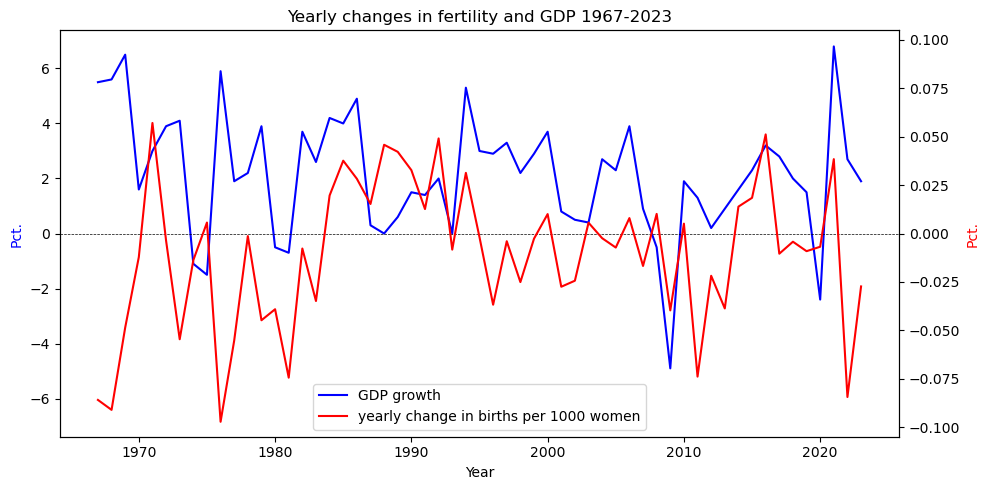

In [12]:
# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# a. Plot GDP growth on the primary y-axis
ax1.plot(inner.index, inner['g'], color='b', label='GDP growth')
ax1.set_xlabel('Year')
ax1.set_ylabel('Pct.', color='b')

# b. Create a secondary y-axis and plot fertility
ax2 = ax1.twinx()  
ax2.plot(inner.index, inner['rate'], color='r', label='yearly change in births per 1000 women')
ax2.set_ylabel('Pct.', color='r')

# c. Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc = 'lower center')

# d. Add title
plt.title('Yearly changes in fertility and GDP 1967-2023')

# e. Align y-axes
mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.5)

# f. Add line through 0
ax1.axhline(0, linewidth=0.5, color='black', linestyle='--')

fig.tight_layout()

# Show plot
plt.show()

Comment on the development of GDP growth and change in births per 1000 women:

The GDP typically rises during periods of economic prosperity and falls during economic downturns. It's reasonable to assume a positive correlation between GDP and the number of births, as economic growth often enhances economic security. This increased security can create greater confidence in the future, thereby encouraging individuals to start families.

We anticipate a delayed response in fertility due to the duration of a pregnancy. This can be seen from the above  graph, notably in the 1970s, 1980s, and following the financial crisis in 2008, where the decline in birth rates follows after the drop in GDP growth.

However, the pattern in the graph appears somewhat arbitrary, which is why we seek to uncover a potential relationship between education level and fertility.

If a relationship between GDP growth and fertility should exist, we would expect the fertility to react with a lag due to the duration of a pregnancy. The graph above shows a somewhat arbitrary pattern, why we seek to uncover a potential relationship between education level and fertility.

In [13]:
hfudd = DstApi('HFUDD10')
display(hfudd.tablesummary(language='en'))
display(hfudd.variable_levels('HFUDD', language='en'))

hfudd1 = DstApi('HFUDD11')
display(hfudd1.tablesummary(language='en'))
display(hfudd1.variable_levels('HFUDD', language='en'))


Table HFUDD10: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2019-06-17T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BOPOMR,105,000,All Denmark,851,Aalborg,False
1,HERKOMST,4,TOT,Total,3,Descendant,False
2,HFUDD,92,TOT,Total,H9099,H9099 Not stated,False
3,ALDER,12,TOT,"Age, total",65-69,65-69 years,False
4,KØN,3,TOT,Total,K,Women,False
5,Tid,14,2006,2006,2019,2019,True


,id,text
0,TOT,Total
1,H10,H10 Primary education
2,H1001,H1001 No education
3,H1010,H1010 Primary school through to 6th grade
4,H1020,H1020 Primary school 7th-9th grade
...,...,...
87,H8080,H8080 PhD programmes
88,H8090,"H8090 Health science, PhD"
89,H8097,"H8097 Higher education not specified, PhD"
90,H90,H90 Not stated


Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BOPOMR,105,000,All Denmark,851,Aalborg,False
1,HERKOMST,4,TOT,Total,3,Descendant,False
2,HFUDD,93,TOT,Total,H9099,H9099 Not stated,False
3,ALDER,12,TOT,"Age, total",65-69,65-69 years,False
4,KØN,3,TOT,Total,K,Women,False
5,Tid,16,2008,2008,2023,2023,True


,id,text
0,TOT,Total
1,H10,H10 Primary education
2,H1001,H1001 No education
3,H1010,H1010 Primary school through to 6th grade
4,H1020,H1020 Primary school 7th-9th grade
...,...,...
88,H8080,H8080 PhD programmes
89,H8090,"H8090 Health science, PhD"
90,H8097,"H8097 Higher education not specified, PhD"
91,H90,H90 Not stated


Note: We had made an interactive plot where different levels of education could be chosen, and the corresponding amount of women with the given level of education were plotted against the fertility rate. However, due to some problems with Git, we no longer have the code. We will recreate it before handing in the project by the end of term. 